In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

In [3]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

**Missing Values:**<br>There are many missing values in data. We can fill the **missing values** in columns with numerical data to the **mean** of that data. For object type columns, we fill it with the item that appears with **maximum** times in that list.

In [4]:
for col in data.columns:
    if data[col].dtype=='object' and data[col].isnull().sum()>0:
        valcounts = data[col].value_counts()
        MostfrequentEntry = valcounts.loc[valcounts == valcounts.max()].index[0]
        data[col].replace(np.nan, MostfrequentEntry, inplace=True)
    elif data[col].dtype != 'object' and data[col].isnull().sum()>0:
        data[col].replace(np.nan,data[col].mean(), inplace=True)


To confirm if it worked properly:

In [5]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

**Converting object into numbers**

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in data.columns[1:]:
    if data[i].dtype == 'object':
        data[i] = le.fit_transform(data[i]) #Fit label encoder and return encoded labels
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


Since there are 12 features in this dataset, we try to find out which of the features are most important for the fitting. Also, we can already remove Loan_ID which is irrelevant for the fitting of dataset.

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
X = data[data.columns[1:12]]
Y = data[data.columns[12]]
LR = LogisticRegression(solver='newton-cg', C = 1e7,multi_class='multinomial')

Here, we use recursive elimination method to rank different features available in the dataset. 

In [8]:
selector = RFECV(LR,step=1,cv=2,scoring='accuracy')
selector = selector.fit(X, Y)
print("\n")
print(np.c_[selector.ranking_,X.columns])
print(selector.grid_scores_)
print("Best number of features = {}".format(selector.n_features_))



[[4 'Gender']
 [2 'Married']
 [6 'Dependents']
 [3 'Education']
 [7 'Self_Employed']
 [11 'ApplicantIncome']
 [10 'CoapplicantIncome']
 [8 'LoanAmount']
 [9 'Loan_Amount_Term']
 [1 'Credit_History']
 [5 'Property_Area']]
[0.80944625 0.80944625 0.80944625 0.80944625 0.80944625 0.80944625
 0.80944625 0.80781759 0.80781759 0.80781759 0.80781759]
Best number of features = 1


The recursive elimination method suggests there is only one feature (which is the credit history), giving the maximum cross validation accuracy. Let's see how the accuracy on the complete training set behaves as the number of features are increased from the most relevant features:

In [9]:
from sklearn.metrics import accuracy_score
print('Features   :  Accuracy score')
for index in range(1,len(selector.ranking_)):
    X_red=X[X.columns[selector.ranking_<=index]]
    LR.fit(X_red,Y)
    prediction=LR.predict(X_red)
    accuracy=accuracy_score(prediction,Y)
    print(X.columns[selector.ranking_<=index].tolist(),': '+str(accuracy))

Features   :  Accuracy score
['Credit_History'] : 0.8094462540716613
['Married', 'Credit_History'] : 0.8094462540716613
['Married', 'Education', 'Credit_History'] : 0.8094462540716613
['Gender', 'Married', 'Education', 'Credit_History'] : 0.8094462540716613
['Gender', 'Married', 'Education', 'Credit_History', 'Property_Area'] : 0.8094462540716613
['Gender', 'Married', 'Dependents', 'Education', 'Credit_History', 'Property_Area'] : 0.8094462540716613
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area'] : 0.8094462540716613
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'LoanAmount', 'Credit_History', 'Property_Area'] : 0.8078175895765473
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area'] : 0.8078175895765473
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_His

**This means most of the features are irrelevant (with negligible weights) and do not change the accuracy.<br>
However, 'loan amount' decreases the accuracy and then 'Coapplicant's Income' increases slightly.<br>
Let's look at the behavior with respect just these features.**

In [10]:
impcolumns=['Credit_History','CoapplicantIncome','Married','LoanAmount']
for index in range(len(impcolumns)):
    X_red=X[impcolumns[:index+1]]
    LR.fit(X_red,Y)
    prediction=LR.predict(X_red)
    accuracy=accuracy_score(prediction,Y)
    print('Features   :  Accuracy score')
    print(X_red.columns.tolist(),': '+str(accuracy))

Features   :  Accuracy score
['Credit_History'] : 0.8094462540716613
Features   :  Accuracy score
['Credit_History', 'CoapplicantIncome'] : 0.8127035830618893
Features   :  Accuracy score
['Credit_History', 'CoapplicantIncome', 'Married'] : 0.8127035830618893
Features   :  Accuracy score
['Credit_History', 'CoapplicantIncome', 'Married', 'LoanAmount'] : 0.8110749185667753


**'Married' is just randomly added from the features which do not effect the accuracy. Clearly, "Coapplicant's Income" adds some more to accuracy and "Loan Amount" makes it difficult to fit the training set. Let's see what does cross validation tells us.**

In [11]:
from sklearn import model_selection
for index in range(len(impcolumns)):
    X_red=X[impcolumns[:index+1]]
    kfold = model_selection.KFold(n_splits=2)
    cv_results = model_selection.cross_val_score(LR, X_red, Y, cv=kfold, scoring='accuracy')
    print('Features   :  Cross validation accuracy score')
    print(X_red.columns.tolist(),': '+str(cv_results.mean()))


Features   :  Cross validation accuracy score
['Credit_History'] : 0.8094462540716613
Features   :  Cross validation accuracy score
['Credit_History', 'CoapplicantIncome'] : 0.8094462540716613
Features   :  Cross validation accuracy score
['Credit_History', 'CoapplicantIncome', 'Married'] : 0.8094462540716613
Features   :  Cross validation accuracy score
['Credit_History', 'CoapplicantIncome', 'Married', 'LoanAmount'] : 0.8078175895765473


This is similar to what we got from RFECV.<br>
Let's make some decision boundaries by importing functions from Irisdataset.ipynb

In [12]:
import nbimporter
import Irisdataset as Plotter

Importing Jupyter notebook from Irisdataset.ipynb


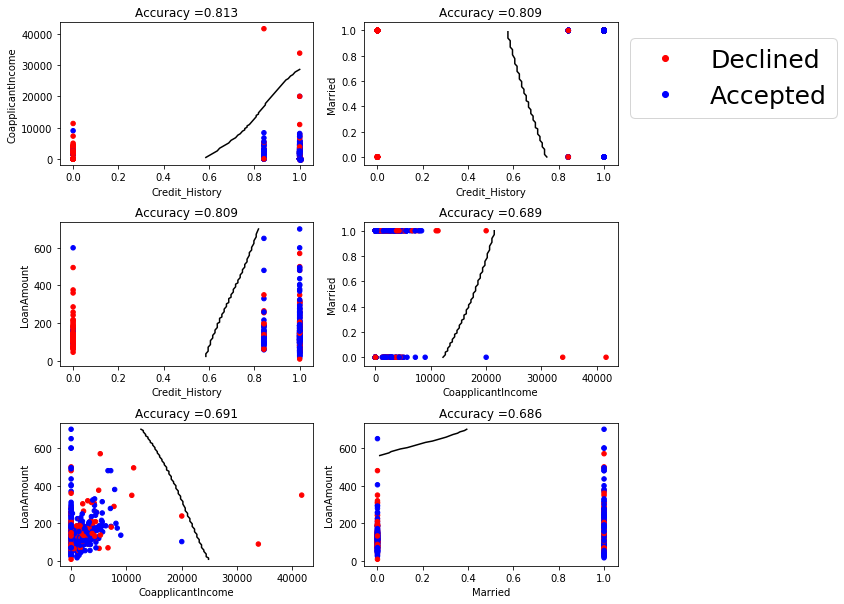

In [13]:
X_red=X[impcolumns]
ColormapforY = Y.copy()
ColormapforY.replace(0.0,'r', inplace=True)
ColormapforY.replace(1.0,'b', inplace=True)
axes=Plotter.plotfeatures(X_red, ColormapforY,decision_boundary=True, model=LR,Y=Y)
Plotter.addlabels(X,ColormapforY,axes,{'r':'Declined','b':'Accepted'})

**Unfortunately, these plots are not much informative as the features are also in binary values (eg. Married/NotMarried). To make these graphs more useful, we can add small random noise to see the points more clearly, while not influencing fittings of the model.**

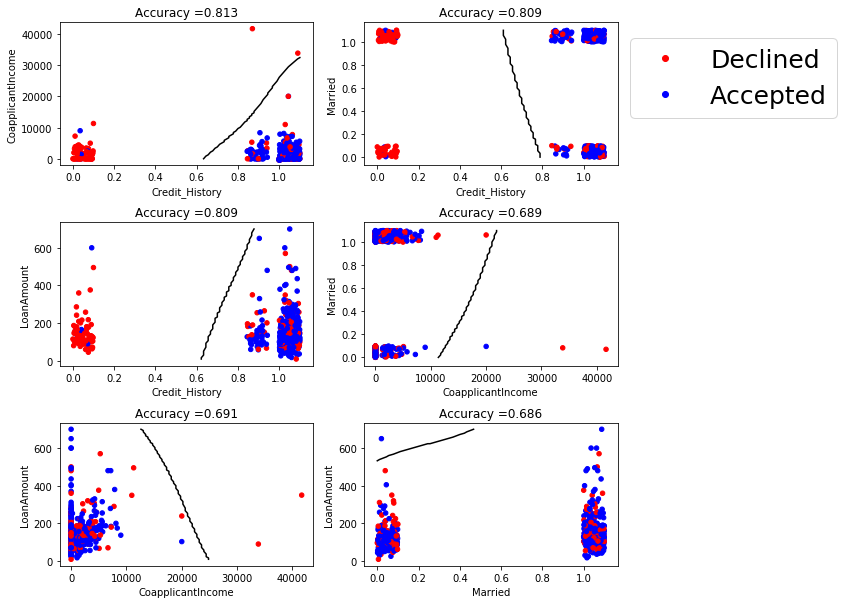

In [14]:
X_red += np.random.rand(X_red.shape[0],X_red.shape[1])*0.1
axes=Plotter.plotfeatures(X_red, ColormapforY,decision_boundary=True, model=LR,Y=Y)
Plotter.addlabels(X,ColormapforY,axes,{'r':'Declined','b':'Accepted'})

**Notice, that the accuracies do not change. But points are slightly scattered around the real values.<br>
Interpretation:<br>
(i) If credit history is 1, then,  it's more likely to have loan accepted.<br>
(ii) The reason that accuracy increases slightly in the case of coapplicant's income because model fits better for some outliers with high income where the loan was declined.<br>
(iii) Loan Amount feature makes it more difficult for classification model to work, as can be seen by the mixture of red and blue dots for its plots.** <br><br>
Let's also observe for different values of credit history, the ratio of accepted and declined loans. 

In [15]:
CH_0=Y[np.abs(X['Credit_History']-0)<0.001]
CH_point8=Y[np.abs(X['Credit_History']-0.842199)<0.001]
CH_1=Y[np.abs(X['Credit_History']-1)<0.001]

In [16]:
CH_0.value_counts()/CH_0.value_counts().sum()

0    0.921348
1    0.078652
Name: Loan_Status, dtype: float64

In [19]:
CH_point8.value_counts()/CH_point8.value_counts().sum()

1    0.74
0    0.26
Name: Loan_Status, dtype: float64

In [20]:
CH_1.value_counts()/CH_1.value_counts().sum()

1    0.795789
0    0.204211
Name: Loan_Status, dtype: float64

Thus, if credit history is 0, it's almost certain that the loan would be rejected. However, if the credit history is 1 or 0.82, there is only 75% chance that loan would accepted.<br>
Let's print some data into files.

In [21]:
import csv
d = np.c_[X[impcolumns],Y]

header = impcolumns +["Loanstatus"]
with open('Loanprediction.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow((header))
    wr.writerows(d)
myfile.close()